<a href="https://colab.research.google.com/github/Leonel-Jeffrey/COMP-1827/blob/main/Clustering_tutorial_21_22_solutions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Cluster analysis

This notebook contains the tutorial for the class on clustering algorithm given as part of the module "Introduction to Artificial Intelligence".

In this tutorial, we will focus on the k-means and the hierarchical clustering algorithms. At times, you will be asked to write your own code. Other times, your task will be that of thinking critically about some aspects of the clustering algorithms by examining both their inner workings and their outputs.

To execute the code, click on the corresponding cell and press SHIFT + ENTER or the little "play" button on the left.

You can also download this notebook to run it locally. However, note that (on top of Python 3+) these are the prerequisites:

Packages needed:
*   Scikit-learn
*   Jupyter notebook
*   Scipy
*   Pandas
*   Numpy
*   Matplotlib




## What clustering is

Clustering algorithms are a set of technique to split a collection of objects into groups (or "clusters") of "similar" items. We want objects belonging to the same cluster to be more similar to one another than to objects belonging to a different group.



## Datasets we will use
All these datasets can be generated or fetched using Scikit-learn or numpy.

1. **Blobs dataset** (see related [Scikit-learn user guide](https://scikit-learn.org/stable/datasets/index.html#sample-generators))

This is a collection of 140 data points that are generated randomly.


2. **Digits dataset** (see related [Scikit-learn user guide](https://scikit-learn.org/stable/datasets/index.html#digits-dataset))

This is a copy of the test set of the UCI ML hand-written digits datasets https://archive.ics.uci.edu/ml/datasets/Optical+Recognition+of+Handwritten+Digits

The data set contains images of hand-written digits: 10 classes where each class refers to a digit. It is pretty much like MNIST, but the images are smaller. 


3. **MNIST**

For completeness, we also download MNIST using tensorflow, as we've done before.
However, we will not use this dataset since we can explore clustering concepts using the scikit-learn digits dataset which runs much faster since it has smaller images and fewer sample.
Later on, you're welcome to replace the digits dataset with the MNIST one. How do the results change? Why?


In [ ]:
!pip install --upgrade scikit-learn

## Imports

In [ ]:
# Define imports
from copy import deepcopy
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm

from scipy.cluster import hierarchy
from scipy.spatial.distance import pdist, squareform, cdist

from sklearn import metrics #import adjusted_rand_score
from sklearn.cluster import KMeans, AffinityPropagation
from sklearn.datasets import make_blobs
from sklearn import datasets
from sklearn.preprocessing import StandardScaler

from time import time
import matplotlib.pyplot as plt
from itertools import cycle


Text(0.5, 1.0, 'digits dataset')

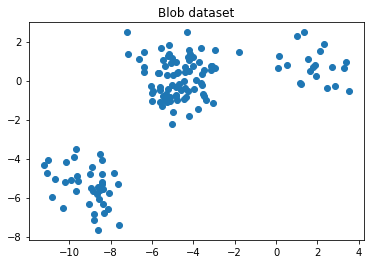

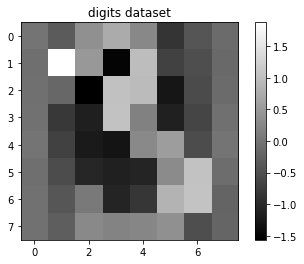

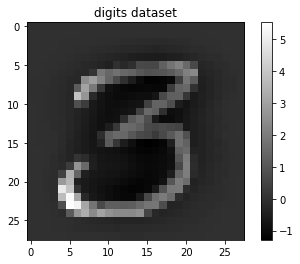

In [ ]:
# Generate all datasets

# Blobs dataset
# Create clusters
blob_n_samples = [40, 80, 20]
random_state = 170

blob_X, blob_y = make_blobs(n_samples=blob_n_samples, random_state=random_state)
# X is the dataset, y are the labels for each data point
plt.figure()
plt.plot(blob_X[:,0],blob_X[:,1],'o')
plt.title('Blob dataset')
# normalise: subtract the mean and divide by the variance
scaler = StandardScaler()
norm_blob_X = scaler.fit_transform(blob_X)

# Digits dataset
digits_X, digits_y = datasets.load_digits(return_X_y=True) #digits
digits_n_samples, digits_n_features = digits_X.shape
# normalise: subtract the mean and divide by the variance
scaler = StandardScaler()
norm_digits_X = scaler.fit_transform(digits_X)

# show an example digit
plt.figure()
try:
  plt.imshow(norm_digits_X[3].reshape(8,8), cmap = 'gray')
  plt.colorbar()
except:
  pass
plt.title('digits dataset')

# For completeness, also download MNIST using tensorflow, as we've done before.
import tensorflow as tf
(mnist_X_raw, mnist_y_raw), (mnist_X_test_raw, mnist_y_test_raw) = tf.keras.datasets.mnist.load_data()
#X_train = X_train_raw / 255 # normalise X_train (see below for why this is not needed here)
#X_test = X_test_raw / 255 # normalise X_test

# We'll only retain a random subset of 5000 images - clustering algorithms can
# take much longer to run than some neural networks, especially since running on CPUs
np.random.seed(0)
indices = np.random.permutation(norm_mnist_X.shape[0])[:7500]
mnist_X_raw = mnist_X_raw[indices]
mnist_y_raw = mnist_y_raw[indices]

# flatten the data into 1D vectors
mnist_X = mnist_X_raw.reshape(mnist_X_raw.shape[0], -1)
mnist_X_test = mnist_X_test_raw.reshape(mnist_X_test_raw.shape[0], -1)

# standardise the data
norm_mnist_X = scaler.fit_transform(mnist_X)
norm_mnist_X_test = scaler.fit_transform(mnist_X_test)

# show an example digit from MNIST
plt.figure()
try:
  plt.imshow(norm_mnist_X[7].reshape(28,28), cmap = 'gray')
  plt.colorbar()
except:
  pass
plt.title('digits dataset')


**Question**: do I have to transform the data to have mean=0 and standard deviation=1?

During the lecture normalisation of the data points was not discussed. The general view is that normalisation is usually a good thing, but, as with everything, one should always think about what is best for the problem at hand.

In the following, we will tend to normalise the data by subtracting the mean and dividing by the variance.

Also, note that standardisign the data this way takes care of the normalisation step you have previously seen for MNIST, that is dividing by 255. This is because the value of the standard deviation depends on the maximum value of the data. If you were to first divide by 255 and then standardise the data, the result would be the same.


## k-means clustering

The k-means algorithm clusters data points across K clusters in a way that minimises the sum over clusters of the squared error between the points in each cluster and the ”cluster centroids”. K-means is a partitioning clustering algorithm, K is an integer number set by the user and the cluster centroids are the mean of all the points belonging to a cluster.

The steps are:
1. Define K and the K initial centroids (usually through random initialisation).
2. Assign each data point to the closest centroid.
3. Update the centroids by taking the mean across all points in the same
cluster.
4. Repeat steps 2 and 3 until no data point moves from one cluster to another
in step 2.

In [ ]:
##### FIRST TASK ########
# Write your own implementation of k-means (parts of it)
# Note: don't worry too much about efficiency
def my_kmeans(data, K, max_iter = 300): # Question 1: which other variables might be useful to define?
  '''
  Arguments:
  data is a numpy matrix of size N (#of points) x F (#features)
  K is the number of clusters
  max_iter is the maximum number of iterations that we go through before stopping

  The following steps are already implemented. 
  How do they relate to what was described in class?
  - Initialisation (here it is done randomly, but there are other strategies)
  - Assignment step
  - Check for convergence

  You need to implement the following steps:
  - Update step (that is, the step that updates the coordinates of the centroids)
  '''

  #current_sse = 0
  N, F = data.shape
  
  # we will collect the sum of squared error at each iteration
  sum_squared_errors = []

  # Initialisation - we just get K random datapoints as our initial centroids
  indices_subset = np.random.choice(N, K)
  # we make a copy so we don't override the coordinates!
  centroids = deepcopy(data[indices_subset])

  # initialise the cluster labels. This keeps track of which cluster each data
  # point is assigned to
  labels = np.ones((N))

  # compute points to centroids pairwise distances, that is the distance
  # between each point and each centroid
  points_to_centroids = cdist(data, centroids, metric = 'sqeuclidean') #N x K matrix

  # keep track of the sum of squared error for each cluster
  current_sse_ks = np.zeros((K))

  for i in range(max_iter):
    # assignment step
    # store previous labels
    previous_labels = deepcopy(labels)
    # assign each data point to the cluster defined by the closest centroid
    # For example a label equal to 1 means that the data point is assigned to cluster 1
    labels = np.argmin(points_to_centroids, axis = 1)

    #########################
    #   YOUR CODE BELOW     #
    #########################
    # update step - new coordinates for the centroids
    for j in range(K):
      # the new coordinates for the centroid of cluster j is the average of the 
      # coordinates of all the points in the cluster.
      # Remember that:
      # 1. the cluster to which a data point is assigned is given by the value of 
      #    the corresponding entry in the 'labels' vector. That is labels[0]==1
      #    means that the first datapoint is assigned to cluster 1
      # 2. data is a numpy matrix of size N (#of points) x F (#features)
      centroids[j] = data[labels == j].mean(axis = 0)

    # update the distances because we have changed the centroids
    points_to_centroids = cdist(data, centroids, metric = 'sqeuclidean')

    # compute the value of the objective function, the sum of squared errors between points and centroids
    for k in range(K):
      # SSE for each cluster
      current_sse_ks[k] = points_to_centroids[labels == k, k].sum()
    # Total SSE
    current_sse = current_sse_ks.sum()

    # Check if we have achieved convergence. That is, check if
    # a. we got to the maximum number of iterations allowed
    # b. the labels haven't changed from the previous iteration
    convergence_check = (i > max_iter) | (np.abs(labels-previous_labels).sum()<1e-13)
    if convergence_check:
      converged = True
      break
  
  return labels, centroids, current_sse


[**Bonus challenge for later**] Modify the code above to include multiple initialisations and pick the best one.

**Check your code works!**

Try it out on the blob dataset with K=3. It should return three clusters similar to the ones seen during the lecture (on the slide with title "What is clustering?"). Since we generated the clusters ourselves, we know what the groud truth is and we can compare against those labels.

Note that comparing the labels generated by the clustering algorithm with the labels from the ground truth is an example of an external validation measure!
One such measure is the **'Rand index'**. The Rand index is a measure of the percentage of correct decisions made by the algorithm. It can be computed as the sum of the number of true positive and the number of true negative divided by the number of all possible comparisons. By true positives, we mean those pairs of points that are in the same cluster in both sets of labels. By true negative, we mean those pairs of points that are in different clusters in both sets of labels. Scikit-learn has a function to compute a Rand index adjusted to take into account the effet of chance. A value of -1 indicates poor similarity, a value of 1 perfect similarity.

The adjusted Rand index is 1.000



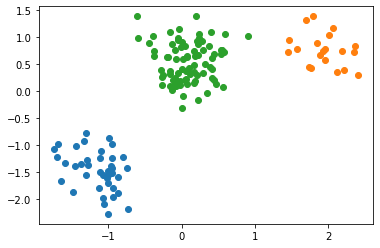

In [ ]:
# Check if it works. 

# k-means algorithm
# function call using the normalised dataset
best_labels, best_centroids, min_sse = my_kmeans(norm_blob_X, k=3)

# plot the results
f = plt.figure()
for k in range(3):
  plt.plot(norm_blob_X[best_labels == k,0], norm_blob_X[best_labels == k,1],'o')

# compute the adjusted rand score (see description above)
adj_rand = metrics.adjusted_rand_score(best_labels, blob_y)

print(f'The adjusted Rand index is {adj_rand:.3f}')
print('')

# Note that simply computing 'your_labels == y' would not work. This is because 
# the same points could be assigned to the same cluster, but the cluster label
# might be different!

# Questions: what could other measures be? Think about it or look up examples.



**A few more details (!)**

The k-means implementation in scikit-learn uses a slightly modified version of the iterative algorithm introduced during the lecture (called the Lloyd's algorithm). This is the Elkan's algorithm. It uses the triangular inequality to avoid many distance calculations when assigning points to clusters. It is much faster than Lloyd, but also more memory expensive.

### The elbow method for k-means

Here, we will explore the use of the elbow method, in particular its limitation by showing a case where it doesn't work.


NOTE:
From here on, we will use the scikit-learn implementation of KMeans (`from from sklearn.cluster import KMeans`).

Some of the parameters you can use in this function are:

1. **n_clusters**: the number of clusters to form as well as the number of centroids to generate.
2. **init**: the method for initialization. Two popular ones are 'k-means++' and 'random'. 'k-means++' selects initial cluster centers for k-mean clustering in a smart way to speed up convergence. 'random': choose n_clusters observations (rows) at random from data for the initial centroids.
3. **max_iter**: maximum number of iterations of the k-means algorithm for a single run.

For the full list see the [KMeans documentation page](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans).

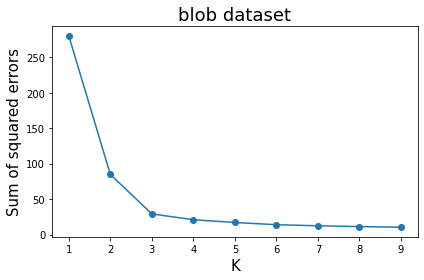

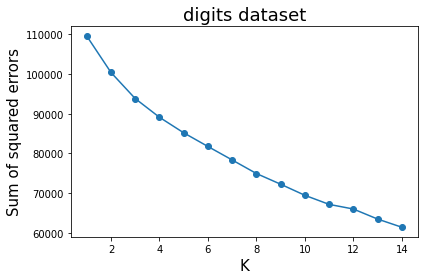

In [ ]:
# Check out the elbow method

def visualise_elbow(data, min_k, max_k, data_name):
  '''
  Runs the KMeans algorithm on data for all values of k between min_k and max_k
  Plots the resulting SSE for the different values of K 
  Returns the vector of resulting SSE
  '''
  all_sses_by_k = []
  for k in range(min_k,max_k):
      kmeans = KMeans(n_clusters=k, random_state =0)
      kmeans = kmeans.fit(data)
      # In Scikit-learn, the sum of squares is contained in the attribute called 'inertia_'
      all_sses_by_k.append(kmeans.inertia_)

  f = plt.figure(figsize = (6,4))
  ##################
  # YOUR CODE HERE #
  ##################
  # what should we plot on the X and Y axis to apply the elbow method?
  # hint: look at the xlabel and the ylabel below...
  plt.plot(range(min_k,max_k), all_sses_by_k, '-o')
  plt.xlabel('K', fontsize = 15)
  plt.ylabel('Sum of squared errors', fontsize = 15)
  plt.title(data_name, fontsize = 18)
  plt.tight_layout()
  return all_sses_by_k

# Apply K Blob (i.e. ideal) dataset
min_k = 1
max_k = 10
_ = visualise_elbow(norm_blob_X,min_k,max_k,'blob dataset')

# Digits (i.e. more like real life) dataset
min_k = 1
max_k = 15
sses_digits = visualise_elbow(norm_digits_X,min_k,max_k,'digits dataset')



**What can we observe from the plots above?**

For example, look at the first graph. The value of the SSE decreases sharply from k=1 to k=2 and from k=2 to k=3, but it decreases only a little from k=3 to k=4 and all the subsequent increases. This suggests that increasing the value of k past k=3 gives 'dimishing returns' and might not be recommended. That is, k=3 seems like a good value for the number of clusters (which is good, since we did create 3 blobs after all!)

**Question**: why do you think the method doesn't seem to produce optimal results for the digits dataset?


The answer is likely related to the fact that the algorithm might not perform well on this dataset in the first place. This can be due to many reasons (noisy data, cluster shapes that deviate too much from the blob-like ideal, etc.).

Maybe we could try a different algorithm (we'll see later) or maybe the data could do with a bit more of preprocessing. If you want to explore a bit more the clustering of this dataset, check out [this page](https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_digits.html#sphx-glr-auto-examples-cluster-plot-kmeans-digits-py) and [this other one](https://scikit-learn.org/stable/auto_examples/cluster/plot_digits_linkage.html#sphx-glr-auto-examples-cluster-plot-digits-linkage-py).

If you want to explore other options for detecting a good value for K from the data, two alternative methods are the CH index (Calinski and Harabasz, 1974) and the gap statistics (Hastie et al., 2013)

### k-means cluster evaluation

The goal of this section is to show some tools that can be used to visually evaluate the performance of clustering.

We've seen in the lecture that the cohesion of a cluster is the sum of distances from each point in a cluster to a centroid. If a cluster has a high cohesion than it might be a good candidate for splitting. Note that cohesion could also be computed using a similarity metric rather than a distance. In which case the terminology would be the opposite and more intuitive (high cohesion = better cluster).

The **silhouette score** is a metric that can be computed for each data point and that combines measures of cohesion and separation.

It can be used to analyse visually the result of the clustering and even to evaluate the optimal (more or less) number of clusters (see [this page](https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html#sphx-glr-auto-examples-cluster-plot-kmeans-silhouette-analysis-py) for more information on the latter process).

In [ ]:
# Here, we use the silhouette score and plot to compare the results of the k-means 
# algorithm using two different initialization methods (random and k-means++)


def bench_k_means(kmeans, name, data, labels):
    """
    Runs the k-means algorithm and computes a set of metrics: the time it takes,
    the sum of squared error (inertia), the adjusted rand score and the silhouette 
    score.
    It is a simplified version from the scikit-learn tutorial here: 
    https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_digits.html
    """
    t0 = time()
    estimator = kmeans.fit(data) #make_pipeline(StandardScaler(), kmeans).fit(data)
    fit_time = time() - t0
    # the 'inertia_' attribute is the final sum of squared distances
    results = [name, fit_time, estimator.inertia_]

    # Compute the adjusted rand score of the cluster labeling given a ground truth.
    results += [metrics.adjusted_rand_score(labels, estimator.labels_)]

    # Add the silhouette score.
    results += [
        metrics.silhouette_score(
            data,
            estimator.labels_
        )
    ]
    
    # Show the results
    formatter_result = (
        "{:9s}\t{:.3f}s\t{:.3f}\t{:.3f}\t\t\t{:.3f}"
    )
    print(formatter_result.format(*results))

print(82 * "_")
print("init\t\ttime\tSSE\t\tadjusted-rand-score\tsilhouette-score")
kmeans = KMeans(init="k-means++", n_clusters=3, n_init=4, random_state=0)
bench_k_means(kmeans=kmeans, name="k-means++", data=norm_blob_X, labels=blob_y)
#bench_k_means(kmeans=kmeans, name="k-means++", data=norm_mnist_X, labels=mnist_y_raw)

kmeans = KMeans(init="random", n_clusters=3, n_init=4, random_state=0)
bench_k_means(kmeans=kmeans, name="random", data=norm_blob_X, labels=blob_y)
#bench_k_means(kmeans=kmeans, name="random", data=norm_mnist_X, labels=mnist_y_raw)

print(82 * "_")


__________________________________________________________________________________
init		time	SSE		adjusted-rand-score	silhouette-score
k-means++	0.021s	29.150	1.000			0.705
random   	0.039s	29.150	1.000			0.705
__________________________________________________________________________________


In this case the two initialisation methods return very similar results.

Next, let's show the silhouette plot for different numbers of clusters.

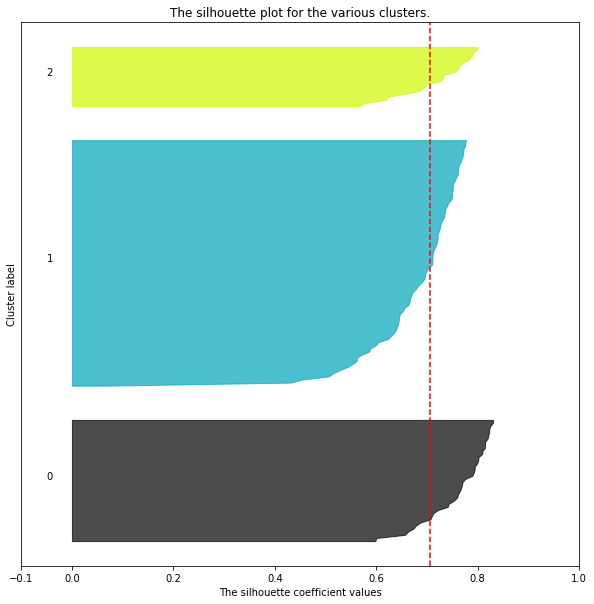

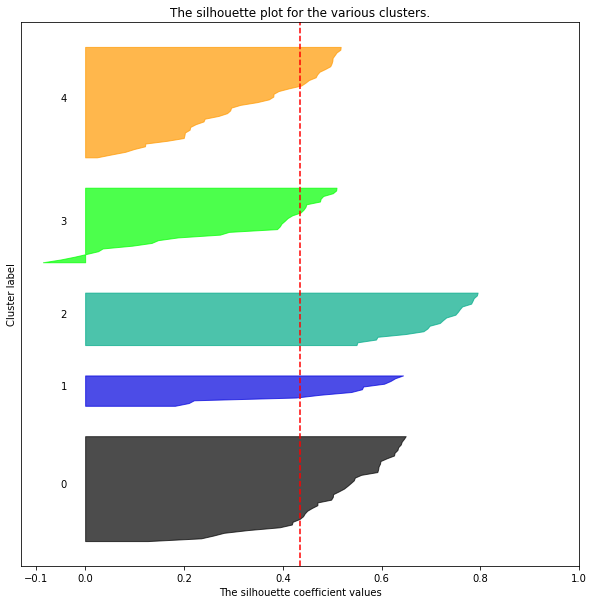

In [ ]:
# Compute the silhouette scores for each sample
def plot_silhouette(data, n_clusters, cluster_labels):

    # compute the silhouette score for each individual sample
    sample_silhouette_values = metrics.silhouette_samples(data, cluster_labels)
    silhouette_avg = metrics.silhouette_score(data, cluster_labels)

    y_lower = 10
    fig = plt.figure(figsize = (10,10))
    ax1 = plt.gca()

    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(
            np.arange(y_lower, y_upper),
            0,
            ith_cluster_silhouette_values,
            facecolor=color,
            edgecolor=color,
            alpha=0.7,
        )

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

# show plot with 3 clusters
n_clusters = 3
kmeans = KMeans(n_clusters=n_clusters, n_init=4, random_state=0).fit(norm_blob_X)
cluster_labels = kmeans.predict(norm_blob_X)
plot_silhouette(norm_blob_X, n_clusters, cluster_labels)

# show plot with 5 clusters
n_clusters = 5
kmeans = KMeans(n_clusters=n_clusters, n_init=4, random_state=0).fit(norm_blob_X)
plot_silhouette(norm_blob_X, n_clusters, kmeans.labels_)


A silhouette score for a data point close to +1 indicate that the point is far away from the neighboring clusters. A value of 0 indicates that the data point is on or very close to the decision boundary between two neighboring clusters and negative values indicate that those data points might have been assigned to the wrong cluster.

As you can see, the plot for 3 clusters has generally higher silhouette scores, while the plot for 5 clusters even has negative silhouette scores! This makes sense, as for the blobs 3 is indeed the correct number of clusters.

### Things to *try*:

1. How do the results change for a different number of clusters?

## Affinity Propagation

The affinity propagation algorithm finds cluster by "passing messages" between the data points.

The algorithms select some data points as the "exemplars" and then assign each of the other data points to the most suitable exemplars.

The number of clusters is given by the number of exemplars.

There are two important parameters: 
1. the **preference**: The preference value affects the number of exemplars, that is of clusters. If using the default similarity metric (that is, the negative of the squared euclidean distance) usual values for the preference will be negative. Higher (that is, closer to 0) values will give more clusters, while lower values will give fewer clusters. If the preference is not given, the value will be set to the median of the input similarities.
2. the **damping** factor: this is a value between 0.5 (included) and 1 (excluded). Higher values slow down the passing of messages between data points.

For more information, see the [documentation page](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.AffinityPropagation.html#sklearn.cluster.AffinityPropagation)

The main advantage of the algorithm is that you don't have to specify the number of clusters. The main disadvantage of the algorithm is that it has high computational complexity, both in terms of time and for memory requirements.

Estimated number of clusters: 130
Adjusted Rand Index: 0.155


<Figure size 432x288 with 0 Axes>

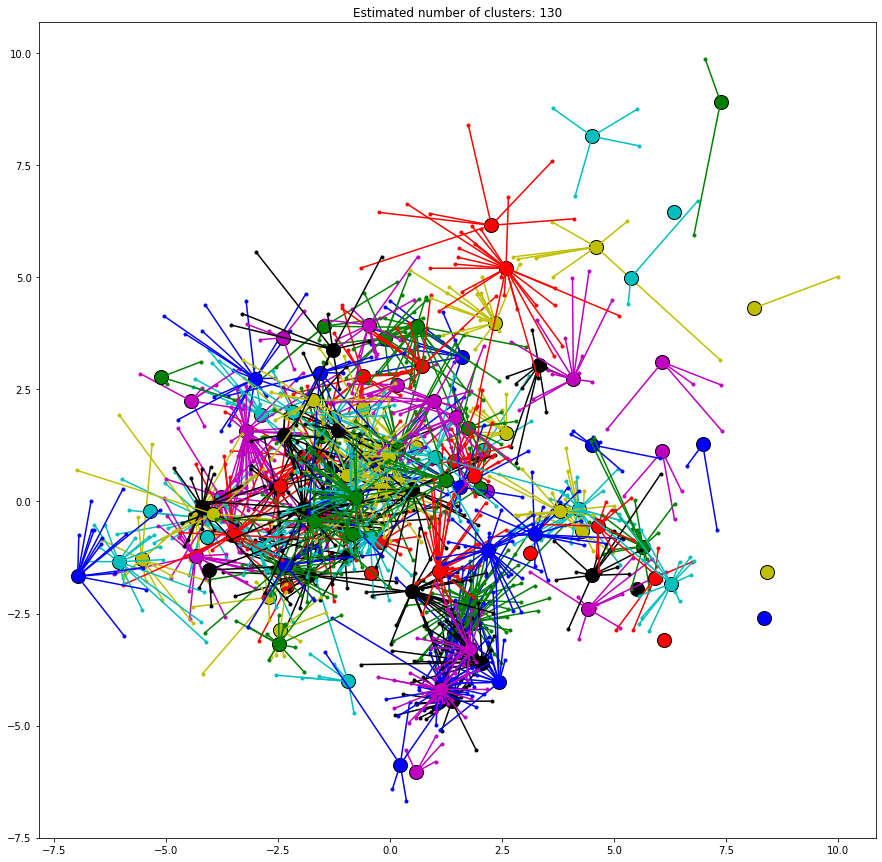

In [ ]:
# Let's cluster the same digits dataset using affinity propagation - is it better?
from sklearn.cluster import AffinityPropagation

# Compute Affinity Propagation
## Use the scikit-learn digits dataset
data = norm_digits_X
true_labels = digits_y
preference = -100

af = AffinityPropagation(preference = preference, damping=.5,
                         random_state=0).fit(data)
# get the cluster exemplars
cluster_centers_indices = af.cluster_centers_indices_
# get the cluster labels
labels = af.labels_

# the number of clusters is given by the number of exemplars
n_clusters_ = len(cluster_centers_indices)

print("Estimated number of clusters: %d" % n_clusters_)

# get and display the adjusted rand index (external validity metric):
print("Adjusted Rand Index: %0.3f" % metrics.adjusted_rand_score(true_labels, labels))

# #############################################################################
# Plot result
plt.close("all")
plt.figure(1)
plt.clf()

# This is just for visualisation purposes - you'll find out about PCA next year! 
# (Sorry for the spoiler...)
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
reduced_X = pca.fit_transform(data)

colors = cycle("bgrcmykbgrcmykbgrcmykbgrcmyk")
_ = plt.figure(figsize = (15,15))
for k, col in zip(range(n_clusters_), colors):
    class_members = labels == k
    cluster_center = reduced_X[cluster_centers_indices[k]]
    plt.plot(reduced_X[class_members, 0], reduced_X[class_members, 1], col + ".")
    plt.plot(
        cluster_center[0],
        cluster_center[1],
        "o",
        markerfacecolor=col,
        markeredgecolor="k",
        markersize=14,
    )
    for x in reduced_X[class_members]:
        plt.plot([cluster_center[0], x[0]], [cluster_center[1], x[1]], col)

_ =plt.title("Estimated number of clusters: %d" % n_clusters_)


In the plot above, the large circles are the exemplars and the lines connect each data point to the exemplar of the cluster to which the data point is assigned.

The algorithm returned more than 100 clusters for only 10 digits!

That sounds wrong... Is clustering images of handwritten digits hopeless?

Not really, but we need to be careful on how we go about it. In particular, consider the fact that we are performing the clustering directly on the pixels, which is not necessarily the best representation for digits. For example, if we have two images of the number 0, but one image is shifted with respect to the other then the euclidean distance between the two images is going to be high even though they represent the same digit! 

Incidentally this is related to why fully connected neural networks with more layers perform better on MNIST and why convolutional neural network are often an even better choice for images.


### Things you could try with affinity propagation

1. Decrease the value of the preference parameter to highly negative values (-1000, -10000, etc.): what happens?
2. Change the value of the damping parameter (.6, .7, .8): what happens?
3. Apply the algorithm to the blob dataset (norm_blob_X): what are the results?
2. **food for thoughts**: what would happen if we tried the clustering on the features extracted from a pre-trained neural network?

# References

* Tan, P., Steinbach, M., Karpatne, A. and Kumar, V. 2018. Introduction to Data Mining (2nd Edition). 2nd ed. Pearson.

* Hastie, T., Tibshirani, R. and
Friedman, J. 2013. The Elements of Statistical Learning: Data Mining, Inference, and Prediction. Springer Science & Business Media.

* Calinski and Harabasz, 1974. A dendrite method for cluster analysis.

# [Bonus] Extra tips for clustering evaluations

The code below shows other types of analyses that we can use to interpret and visually evaluate the results of the clustering algorithm.

They are only meant to guide for the algorithm development, rather than to give definitive answers as to whether a certain clustering is good or bad.


Text(0.5, 0, 'cluster ID')

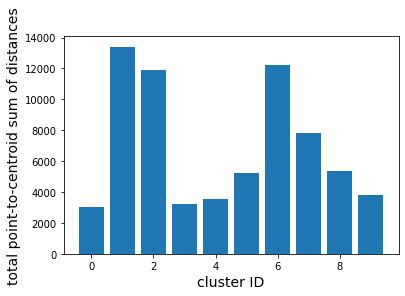

In [ ]:
# Clustering evaluation
# Compute cohesion for all clusters and check the results

# run k-means on the digits dataset
K = 10
kmeans = KMeans(n_clusters = K, random_state =0).fit(norm_digits_X)

# extract attributes
centroids = kmeans.cluster_centers_ # the centroids
labels = kmeans.labels_ # the labels

# compute cohesions and the cluster size for each cluster.
total_sum_of_distance = np.zeros((K))
cluster_size = np.zeros((K))
points_to_centroids = cdist(norm_digits_X, centroids, metric = 'sqeuclidean')
for k in range(K):
  total_sum_of_distance[k] = points_to_centroids[labels == k, k].sum()
  cluster_size[k] = (labels == k).sum()

# plot cohesion value for each cluster
plt.figure()
plt.bar(range(K),total_sum_of_distance)
plt.ylabel('total point-to-centroid sum of distances', fontsize = 14)
plt.xlabel('cluster ID', fontsize = 14)



Text(0.5, 0, 'cluster ID')

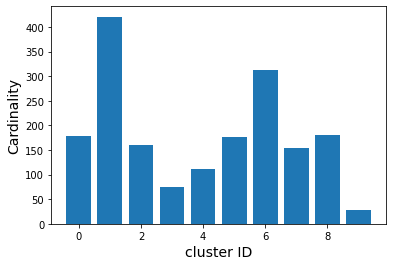

In [ ]:
# plot cardinality
plt.figure()
plt.bar(range(K),cluster_size)
plt.ylabel('Cardinality', fontsize = 14)
plt.xlabel('cluster ID', fontsize = 14)


Text(0.5, 0, 'Cardinality')

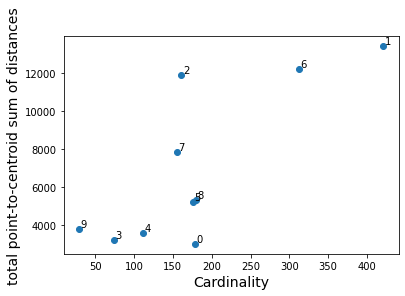

In [ ]:
# Cohesion versus cluster size.
# Intuitively, bigger clusters should be more likely to have a high sum of distances
# A small cluster with a high sum of distance might contain a subset of few points
# that are very far away from the centroid
plt.plot(cluster_size,total_sum_of_distance,'o')
for k in range(K):
  plt.text(cluster_size[k]+2, total_sum_of_distance[k]+100, f"{k}")
plt.ylabel('total point-to-centroid sum of distances', fontsize = 14)
plt.xlabel('Cardinality', fontsize = 14)


The clusters seem to pretty much have a higher sum of distances if they are larger. However, some clusters (like cluster 0) might have a lower sum of distance given the size. Note that through visual inspection only, we can NOT be sure this is a real effect and not the results of random chance.

In [ ]:
# since we have the true labels, how well does the cluster do?
adj_rand = adjusted_rand_score(labels, digits_y)

print(f'The adjusted Rand index is {adj_rand:.3f}')
print('')


The adjusted Rand index is 0.465



It's better than chance, but we could do better!

[**Bonus challenge**] Which digits get mis-clustered the most?